# Inventory Optimization

**Author: Yiran Jing** <br />
**Dec 2019**

Inventory optimization is a method of balancing `capital investment` objectives and `service-level goals` over a large assortment of stock-keeping units (SKUs) while taking demand and supply volatility into account. Simply, optimizing inventory means finding the **perfect balance between demand and supply**

###  Motivation:
From one side, we want to avoid costly shortages, on the other hand, Inventory consumes space, gets damaged, and sometimes becomes obsolete — and carrying surplus inventory costs the organization. Over time, massive amounts of unused or obsolete inventory translate to waste and loss. 

## Goal of Inventory optimization:
Optimize `Capacity` and `facing` of items, taking into account of `selling margin`.

Different items have different pricing and margin rate, therefore, we should consider different weight (**Inventory Segmentation**) to their quantity sold comparision.  **research and algorithm should apply here** 

We need be able to identify demand change over time, **Demand forecast** should apply here.

#### Main concept:
- COGS: cost of gold sold
- FM: Front margin
- SM: Selling margin
- GS: gross sale
- NS: net sale
$$ FM\ \ =\ \frac{GS-COGS}{GS} $$

$$SM\ \ =\ \frac{GS-discount\ -\ COGS}{GS}=\frac{NS\ -COGS}{NS}\ $$

#### DataSet Description
1. `Distribution Report - Auckland Departures - July19.csv` 
2. `sales_newzealand.csv`: monthly sale data (**April-Sep**) (half year, with the middle month is July)

#### key Assumption:
- Assume the `distribution report` is update every three month, and since the current distribution report we have is July, the analysis data we based on are **from July to Sep**
- Assume total store `facing`
- Assume total store `Capacity`  
- Assume total store `bags` 


***

## Summery of Important Findings in EDA section:
1. Identify three kinds of items, which have to been removed from the inventory analysis: 
    1. New_items
       - The items are not in `distribution report`, but have sale history from July-Sep
       - save them to `new_SKU.csv`
    2. Removed_items
       - The items are in `distribution report`, but have no sales from July-Sep
       - save them to `removed_SKU.csv`
    3. Check_items 
       - The items are in `distribution report`, but have no sales from Apr-Sep
       - save them to `check_SKU.csv`
       - There might be two reasons for this collection
          1. file has not been update
          2. the items are truly in the store, but cannot sold out 
    4. Incorrect_record_items
       - The items has extremely high ratio of capacity/facing. (>6)
       - Either facing or capacity is incorrect. Need to report to store manager.
       - Save them in `Incorrect_record_items.csv`
    5. Items Depth < 2 (same as Capacity < Facings *2)
       - e.g. Capacity = Facings = 1, incorrect
       - e.g Facing = 3, Capacity = 5, incorrect
       - Capacity should > Facing. 
       - Save them in `Depth2_items.csv`
       
       
       
 <br />
 <br />
 <br />
 <br />
1. **We can ignore Seasonal or Time effect for 15_ Liquor currently**. Since Sale performance of Five Classification looks stable over time (Sep-Dec): <br />
   - Each class keeps similar sell pattern in the past 4 month
   - **Demand forecast** model should apply here since we cannot ignore time effect in the practice. 
1. **The main factor of classification and capacity decision is sale quantity, rather than sales amount or sell Margins.** Since average sell margins are quite similar for each classifications, and from scatter below we can see that both classification and capacity show strong linear relationship with sale quantity, rather than sale amount.(maybe need more support files to confirm)

#### Sold Quantity of each classification:
1. On average, the sale quantity of `A+` class items are significantly higher than other classes (85%).
2. In total, `A+` class items and `A`class items account for most sale amount (33+36 = 70%)
3. `C` and `D` class items are less popular. 

#### Sell Margin of each classification: 
1. **The `average sell margin` of `D` class is higher than others**, and other classes have similar sell margins on average.
2. Few items have relatively low sell margins (<0.4).
    - In `B` or `A` class
    - Some of them have high sell qty but cheap
    - Some of them are expense but low sell qty
    
3. Few items have high margins (>=0.8)
    - items are in `D`, `B` classes
    - They are all below the mean of price ($70)
    - `JAGERMEISTER 20 CL` is very popular (around 50-60 sell qty each month). Others are not popular.
    
#### Price of each classification:
1. Luxury items maiunly in `C` and `B` class
4. Cheap item generally in `A` and `A+` class

#### Insights from 8 pie charts below:
1. **The Capacities of some `A+` items might need to increase**, since avgQtySold (%) > avgCapacity (%) and overallQtySold (%) > overallCapacity (%), given sell margins overall are similar, and facing(%) is similar with QtySold (%).
1. **The Facing of some `A` items might need to decrease**, since on average, QtySold (%) < Facings (%) and Capacity (%) < Facings (%)
1. **The capacity of some `C` and `B` items might need to decrease**, since totalQtySold (%)< totalcapacity(%).  
1. **Some `A+` and `A` need less facing**. (from scatter plot: Relationship between Facing and Sold quantity for each SKU) since they have quite high facing, but relatively low sale quantity. 
   


***
### Next Step Suggestion:
1. Identify the items with apparently unreasonable capacity/facings: <br /> (**see CheckItems_InventoryOptimization.ipynb for the calculation details**)
For each item, calculate and compare the QtySold (%), Facings (%) and Capacity (%). Then we can identify items which has **the biggest issue**. <br />
The real optimization is quite hard/impossible, since it is multi-factor related result and can easily change over time. Or say, aiming optimize result is too early now. So I think firstly, we should identify the items with apparently unreasonable capacity/facings. 

2. **Inventory Segmentation within each calss**:  (since Different items have different price, sale qty and margin rate, therefore, we should consider different weight) 
   - Choice 1: set rules by ourselves, for example, separate groups within `C` class according to sell margins，promo or not, and sale quantities, (but subjective bias here, and decide threshold is tricky)
   - Choice 2: Classification using unsupervised ML method, and then we comfirm/check the model result.
   - Choice 3: choice 1 + choice 2


5. cheap , luxuries item （dash board）for detailed visualization



***


In [75]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from Inventory_opti_helperFunction import *

%matplotlib inline
sns.set_style("whitegrid")

In [76]:
import findspark
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
# Import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
import re

findspark.init()

"""
Build the SparkSession
"""
# getOrCreate(): get the current Spark session or to create one if there is none running
spark = SparkSession.builder \
   .master("local") \
   .appName("Inventory Opti Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext # create a SparkSession object from your SparkContext

# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=local appName=Inventory Opti Model>
2.4.4


#### Load data

In [77]:
df = spark.read.csv("../data/RawData/sales_newzealand.csv", header=True)
dist_df = spark.read.csv("../data/RawData/Distribution Report - Auckland Departures - July19.csv", header=True)
Subcat_info = spark.read.csv("../data/RawData/SubCateogoryInfo.csv", header=True) 
Vendor_info = spark.read.csv("../data/RawData/Vendor_info.csv", header=True) 

## Data Cleaning

In [78]:
dist_df = clean_dist_df(dist_df)
df = Data_clean_and_merge(df, dist_df, Subcat_info, Vendor_info)
month_merge = merge_dataset(df)

In [79]:
month_merge_early = month_merge.filter(month_merge.month < 7)  # April- June
month_merge_late = month_merge.filter(month_merge.month >= 7)  # July - Sep

In [80]:
month_merge_early.toPandas().to_csv('../data/CleanedData/month_merge_early.csv', 
                             index=False, encoding='utf-8')
month_merge_late.toPandas().to_csv('../data/CleanedData/month_merge_late.csv', 
                             index=False, encoding='utf-8')

## Identify items which have potential issues
There are three items we will removed from the inventory analysis: 
1. New_items
   - The items are not in `distribution report`, but have sale history from July-Sep
2. Removed_items
   - The items are in `distribution report`, but have no sales from July-Sep
3. Check_items 
   - The items are in `distribution report`, but have no sales from Apr-Sep
   There might be two reasons for this collection
   1. file has not been update
   2. the items are truly in the store, but cannot sold out 
4. Incorrect_record_items
       - The items has extremely high ratio of capacity/facing. (Ratio >6)
       - Either facing or capacity is incorrect. Need to report to store manager.    
5. Items Depth < 2 (same as Capacity < Facings*2 )
       - e.g. Capacity = Facings = 1, incorrect
       - e.g Facing = 3, Capacity = 5, incorrect
       - Capacity should > Facing. 

In [81]:
check_item = find_check_item(month_merge, dist_df)
Removed_item = find_removed_item(month_merge_late, month_merge_early, dist_df)
New_item  = find_new_item(month_merge_late, dist_df)

In [82]:
New_item.count()

81

In [83]:
Removed_item.count()

0

In [84]:
check_item.count()

59

In [85]:
### Save these item to CSV
Removed_item = Removed_item.toPandas()
Removed_item.to_csv('../data/Output/IssuedItem/removed_SKU.csv', 
                             index=False, encoding='utf-8')

New_item = New_item.toPandas()
New_item.to_csv('../data/Output/IssuedItem/new_SKU.csv', 
                             index=False, encoding='utf-8')
### Save these item to CSV
check_item = check_item.toPandas()
check_item.to_csv('../data/Output/IssuedItem/checked_SKU.csv', 
                             index=False, encoding='utf-8')

#### Join dataset for inventory opti analysis 

In [86]:
"""
Inner join Two tables
"""
# Join the DataFrames
month_merge = dist_df.join(month_merge_late, on="MatID", how="inner")

### Incorrect_record_items


In [91]:
Incorrect_record_items = month_merge.filter(col('Capacity')/col('Facings') >6)
Incorrect_record_items = Incorrect_record_items.withColumn("Depth", col('Capacity') / col('Facings')).select('MatID',
 'SKU',
 'Facings',''
 'Capacity',
 'Depth',                                                                                  
 'DaysSupply',
 'Classification',
 'month',
 'SubCategory',
 'Vendor',
 'totalMonthlyNetSale',
 'totalMonthlyGrossSale',
 'avgCOGS',
 'totalMonthlyQtySold',
 'Price',
 'SellMargin',
 'avgFrontMargin')
Incorrect_record_items.toPandas().to_csv('../data/Output/IssuedItem/Incorrect_record_items.csv', 
                             index=False, encoding='utf-8')

In [ ]:
Incorrect_record_items = Incorrect_record_items.toPandas()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

sns.swarmplot(x="Classification", y="Capacity", data=Incorrect_record_items, hue = 'SubCategory', ax = axes[0])
axes[0].set_title("Capacity for High Capacity/Facing SKU", fontsize=20)

sns.swarmplot(x="Capacity", y="totalMonthlyQtySold", data=Incorrect_record_items, hue = 'SubCategory', ax = axes[1])
axes[1].set_title("Monthly Qty Sold and Capacity for High Capacity/Facing SKU", fontsize=20)
plt.show()

Incorrect_record_items.hist(column='Facings')
plt.show()


### Items Depth < 2

In [92]:
Depth2_items = month_merge.filter(col('Capacity')/col('Facings') <2)
Depth2_items = Depth2_items.withColumn("Depth", col('Capacity') / col('Facings')).select('MatID',
 'SKU',
 'Facings',''
 'Capacity',
 'Depth',                                                                                  
 'DaysSupply',
 'Classification',
 'month',
 'SubCategory',
 'Vendor',
 'totalMonthlyNetSale',
 'totalMonthlyGrossSale',
 'avgCOGS',
 'totalMonthlyQtySold',
 'Price',
 'SellMargin',
 'avgFrontMargin')
Depth2_items.toPandas().to_csv('../data/Output/IssuedItem/Depth2_items.csv', 
                             index=False, encoding='utf-8')

### Save the dataset for Inventory opti analysis

In [35]:
"""
Print the number of row and columns in the joined dataset
"""
month_merge = month_merge.filter(col('Capacity')/col('Facings') <=6)
print((month_merge.count(), len(month_merge.columns)))

month_merge.toPandas().to_csv('../data/CleanedData/month_merge_total.csv', 
                             index=False, encoding='utf-8')

(1472, 16)


## EDA

In [36]:
"""
Number of items in each Classification
"""
class_data = dist_df.groupby("Classification")
count = class_data.count().show()

+--------------+-----+
|Classification|count|
+--------------+-----+
|             B|  231|
|             D|   12|
|             C|  239|
|             A|  134|
|            A+|   15|
+--------------+-----+



In [37]:
month_merge = month_merge.toPandas() # convert to panda dataframe for plot 

#### Price

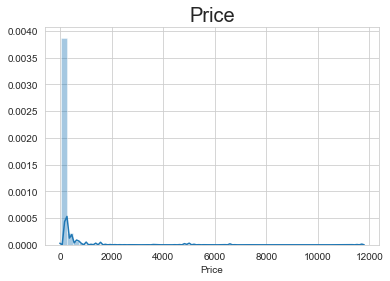

In [38]:
ax = sns.distplot(month_merge['Price'])
ax.set_title("Price", fontsize=20)
plt.show()

- heavy right skew 
- need log transformation before modelling

In [39]:
month_merge['Price'].describe()

count     1472.000000
mean       164.216029
std        555.127575
min         14.000000
25%         49.000000
50%         76.425534
75%        119.000000
max      11758.000000
Name: Price, dtype: float64

### Sell Margin

In [40]:
month_merge['SellMargin'].describe()

count     1472.000000
mean      1610.864490
std       3324.302495
min       -269.640015
25%        371.327507
50%        790.489990
75%       1590.974915
max      53821.046875
Name: SellMargin, dtype: float64

### Relationship between the average of GS and NS for each SKU

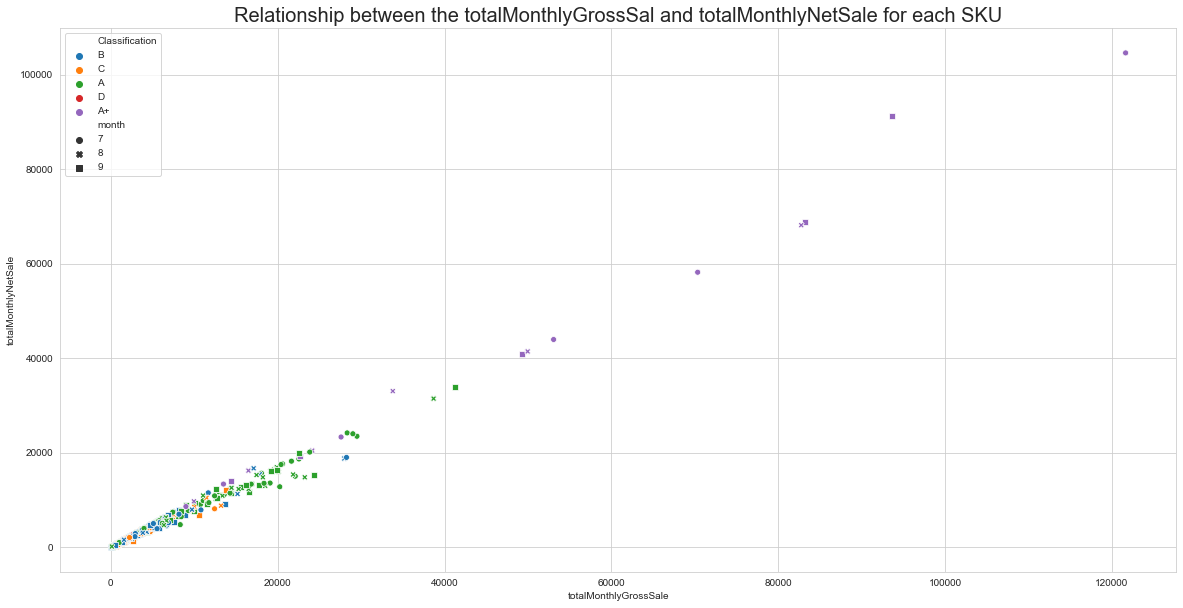

In [41]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="totalMonthlyGrossSale", y="totalMonthlyNetSale", 
                     style="month", hue = "Classification", data=month_merge)
ax.set_title("Relationship between the totalMonthlyGrossSal and totalMonthlyNetSale for each SKU", fontsize=20)
plt.show()

In [42]:
month_merge['totalMonthlyNetSale'].corr(month_merge['totalMonthlyGrossSale'])

0.9952759101963518

The correlation of avg(NetSales) and avg(GrossSales) is quite high (0.996), also based on scatter plot, NS and GS includes quite similar information. Thus in the following analysis, I choice Gross sale only

Also, since $discount = GS - NS$, and GS includes similar info with NS, so there is no valuable information in discount column

### Relationship between the average of Qty sold and Facing for each SKU

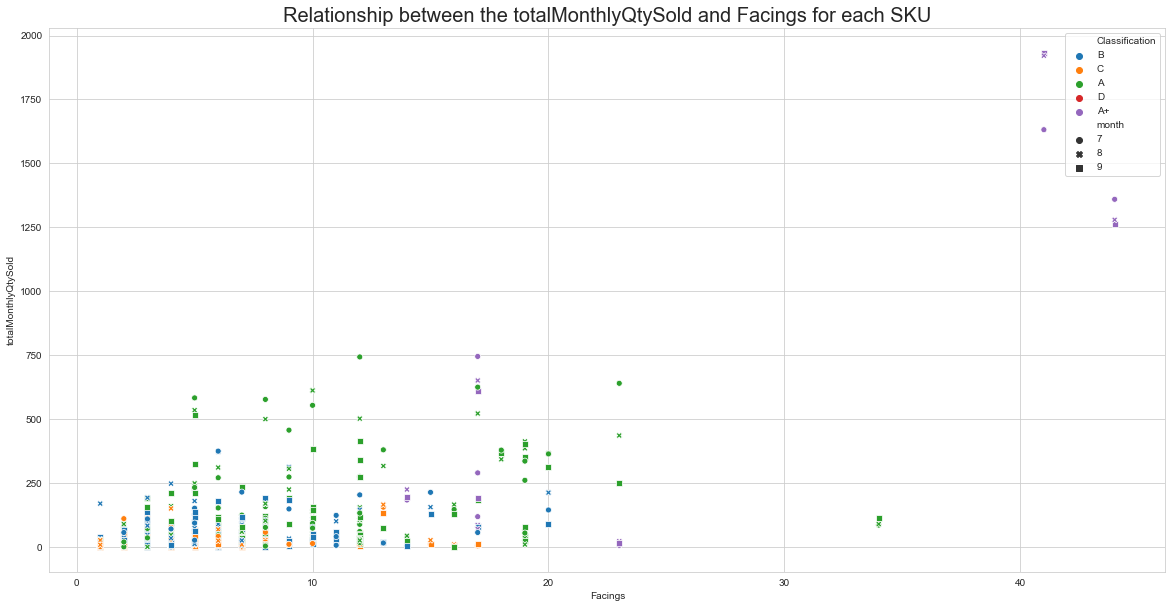

In [43]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Facings", y="totalMonthlyQtySold", style="month", hue = "Classification", data=month_merge)
ax.set_title("Relationship between the totalMonthlyQtySold and Facings for each SKU", fontsize=20)
plt.show()

In [44]:
month_merge['Facings'].corr(month_merge['totalMonthlyQtySold'])

0.6244415718061291

From plot above we can see that 
- There is positive (not strong enough) relationship between facing and the qty sold. But note that there is no clear causality between this two factors. 
- `A+` class items generally have more facings and more qty sold.

### Sale performance of Five Classification over time

<Figure size 2520x720 with 0 Axes>

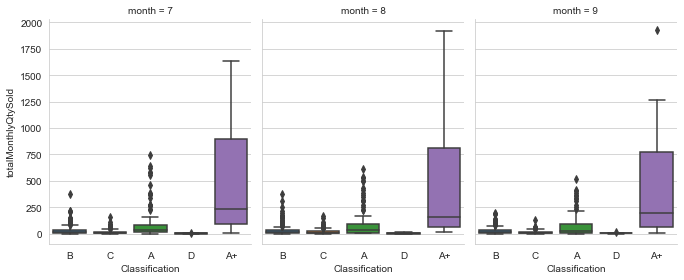

In [45]:
plt.figure(figsize=(35,10))
g = sns.catplot(x="Classification", y="totalMonthlyQtySold",
                 #hue="Classification", 
                 col="month",
                 data=month_merge, 
                 kind="box",
                 height=4, aspect=.8)
plt.show()

<Figure size 2160x1080 with 0 Axes>

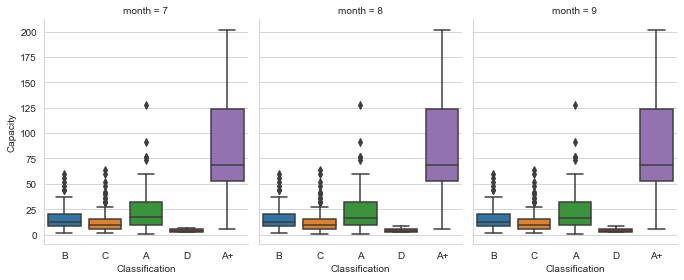

In [46]:
plt.figure(figsize=(30,15))
g = sns.catplot(x="Classification", y="Capacity",
                 #hue="Classification", 
                 col="month",
                 data=month_merge, kind="box",
                 height=4, aspect=.8)
#g.fig.suptitle('Relationship between Classification and Capacity over time', fontsize=20) 
plt.show()

<Figure size 2160x1080 with 0 Axes>

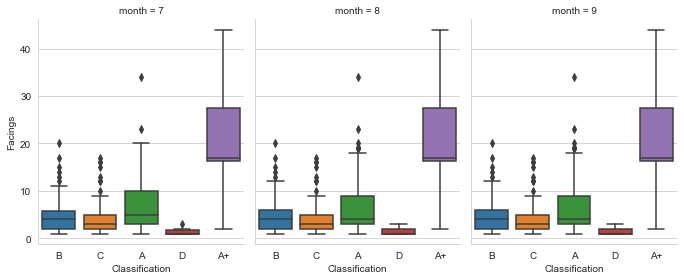

In [47]:
plt.figure(figsize=(30,15))
g = sns.catplot(x="Classification", y="Facings",
                 #hue="Classification", 
                 col="month",
                 data=month_merge, kind="box",
                 height=4, aspect=.8)
#g.fig.suptitle('Relationship between Classification and Capacity over time', fontsize=20) 
plt.show()

From 9 box plots above we can see that:
1. Most popular items are in A+ items (sold most)
1. Each class keeps similar sell pattern in the past 3 month 

  Classification  totalMonthlyNetSale
0              A         1.590595e+06
1             A+         7.003028e+05
2              B         1.016511e+06
3              C         6.683994e+05
4              D         2.687511e+04

Sell Margin % means: TotalSellMargin / totalMonthlyNetSale within classifiction 


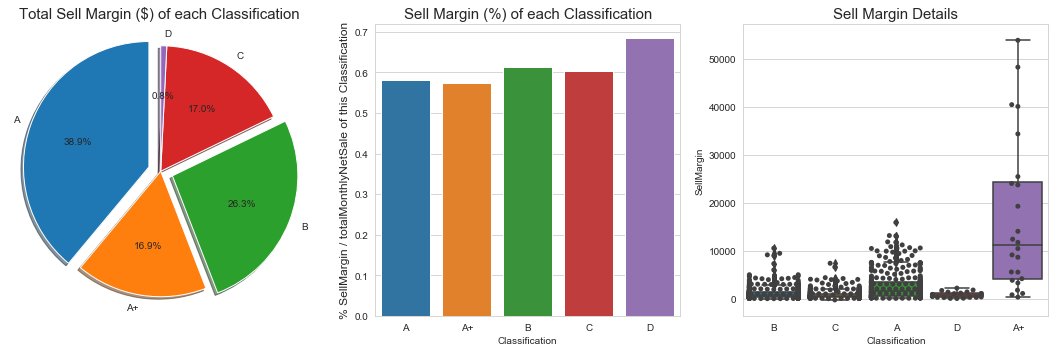

In [48]:
pie_chart_margin("SellMargin", month_merge, 'Total Sell Margin ($) of each Classification', 
                         'Sell Margin (%) of each Classification', 
                         explode = (0.1, 0, 0.1, 0, 0))

Plot for totalMonthlyQtySold


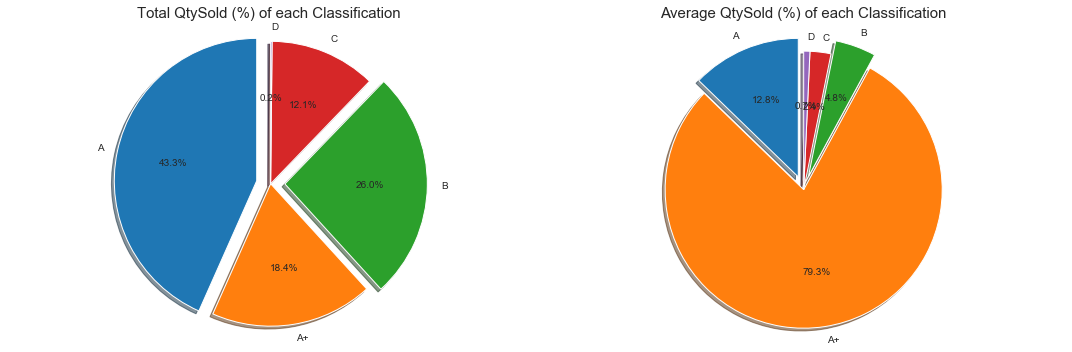

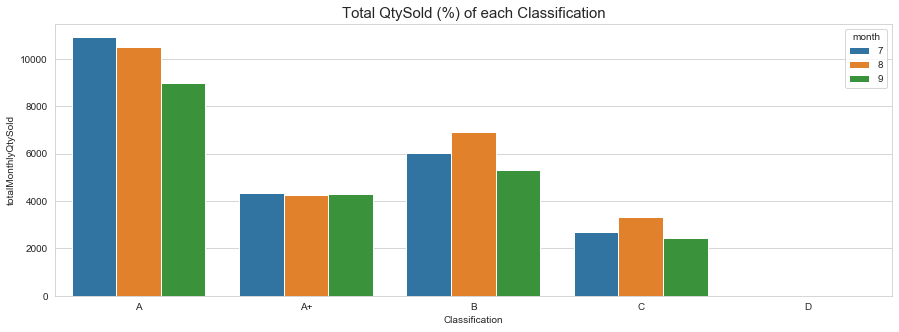

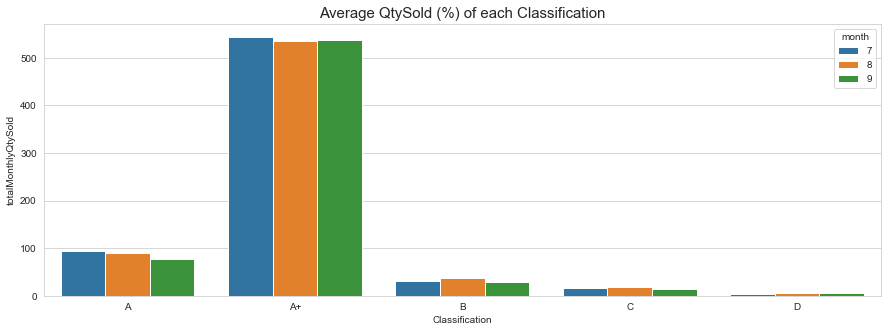


------------------------------------------------------------------
Plot for Capacity


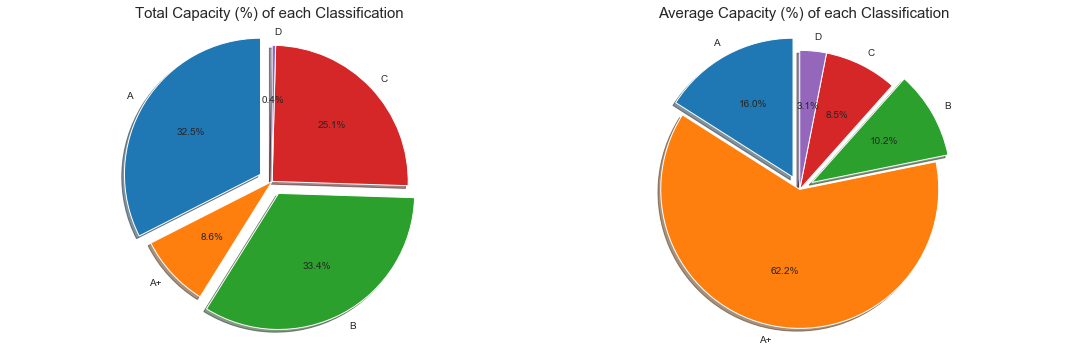

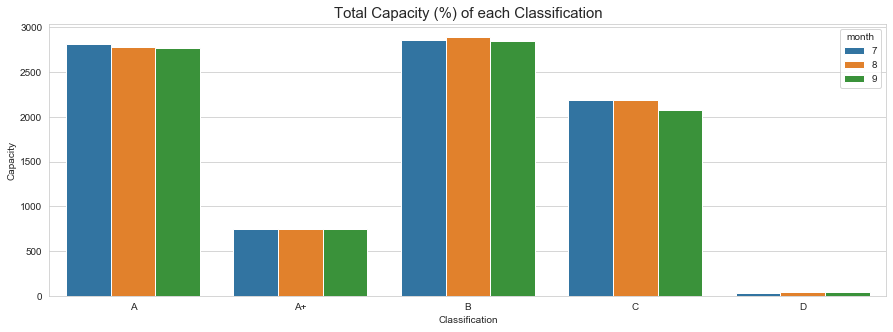

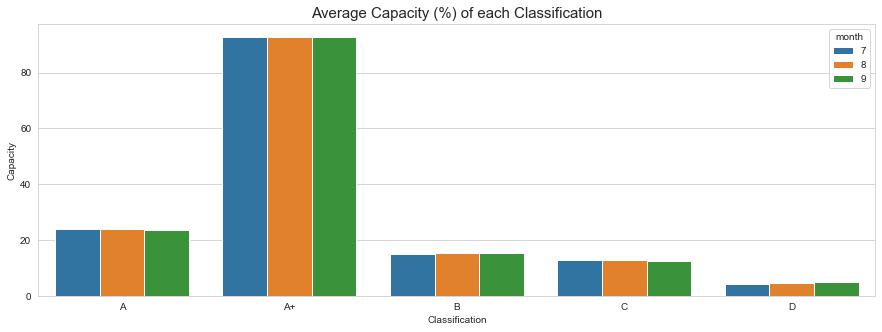


------------------------------------------------------------------
Plot for Facings


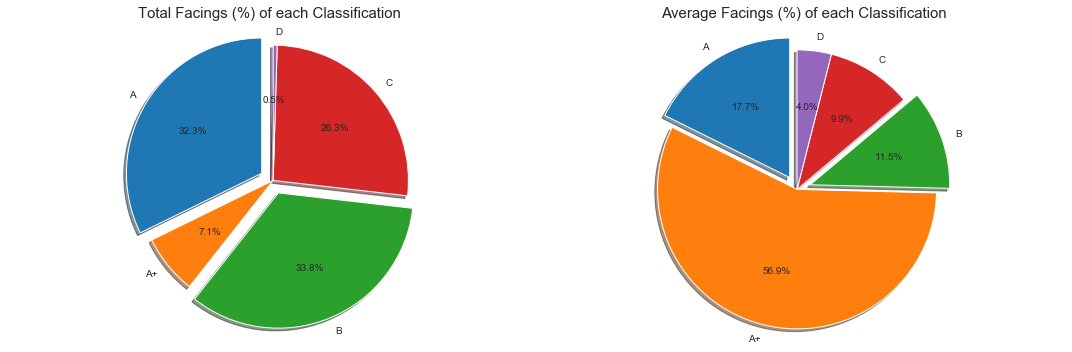

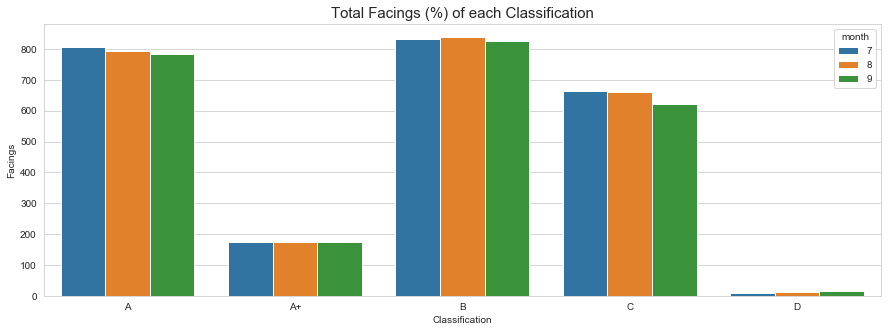

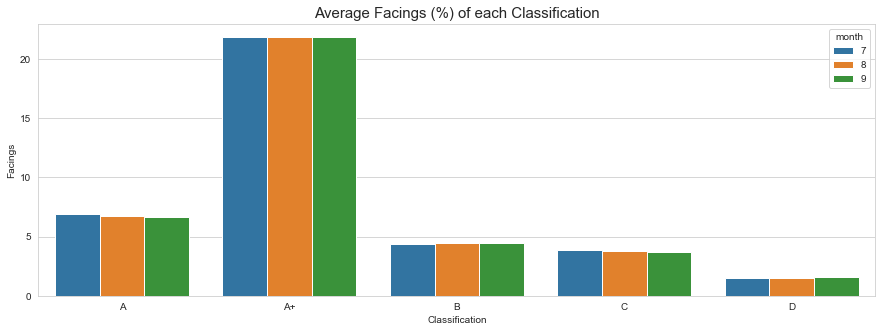


------------------------------------------------------------------


In [49]:
pie_chart_classification("totalMonthlyQtySold", month_merge, 'Total QtySold (%) of each Classification', 
                         'Average QtySold (%) of each Classification', 
                         explode = (0.1, 0, 0.1, 0, 0), calss_choice = 'Classification')
pie_chart_classification("Capacity", month_merge, 'Total Capacity (%) of each Classification', 
                         'Average Capacity (%) of each Classification',
                         explode = (0.1, 0, 0.1, 0, 0), calss_choice = 'Classification')
pie_chart_classification("Facings", month_merge, 'Total Facings (%) of each Classification', 
                         'Average Facings (%) of each Classification',
                         explode = (0.1, 0, 0.1, 0, 0), calss_choice = 'Classification')

From 8 pie charts above we can see that:
1. In total, `A+` class items and `A`class items account for most sale amount (33+36 = 70%), but on average, the sale quantity of `A+` class items are significantly higher than other classes (85%).
1. **The `average sell margin` of `D` class is higher than others**, and other three class have similar sell margins on average.
1. **The Capacities of some `A+` items might need to increase**, since avgQtySold (%) > avgCapacity (%) and overallQtySold (%) > overallCapacity (%), given sell margins overall are similar, and facing(%) is similar with QtySold (%).
1. **The Facing of some `A` items might need to decrease**, since on average, QtySold (%) < Facings (%) and Capacity (%) < Facings (%)
1. The capacity of some `C` and `B` items might need to decrease, since totalQtySold (%)< totalcapacity(%).  

### Price dist of Five Classes

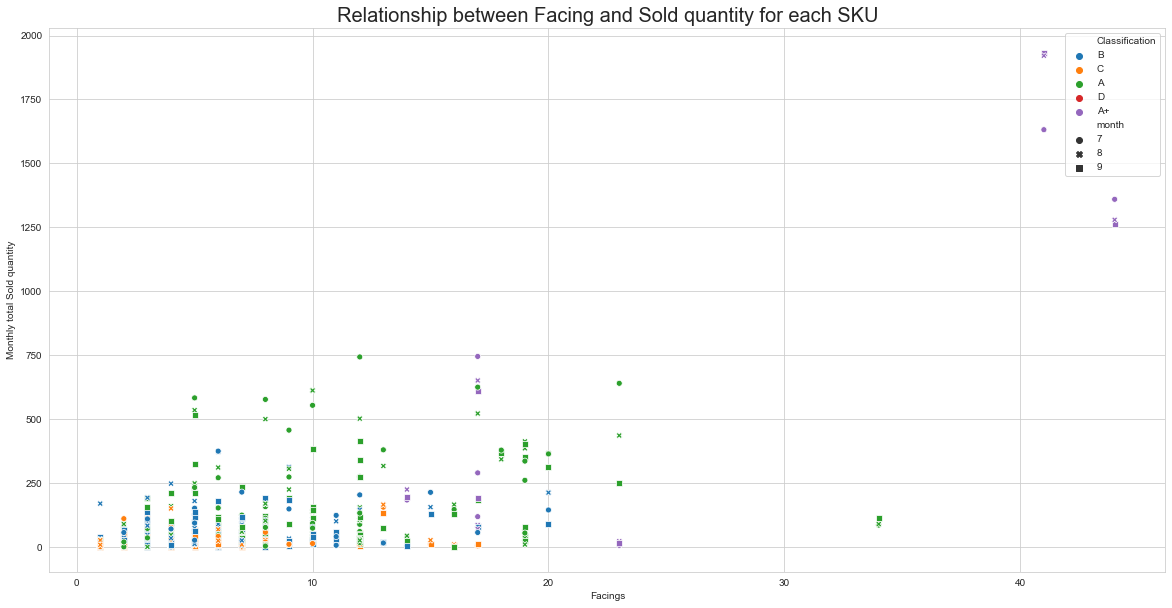

In [50]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Facings", y="totalMonthlyQtySold", hue="Classification", style='month',data=month_merge)
ax.set_title("Relationship between Facing and Sold quantity for each SKU", fontsize=20)
ax.set_ylabel("Monthly total Sold quantity")
plt.show()

From the plot above, we can see that facing arrangement is not reasonable:
1. Some `A+` might need more facing, since has high sale qty, but relatively low facings
2. Some `A+` and `A` need less facing. (low sale quantity, but high facing.)

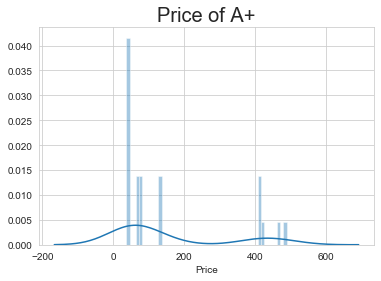

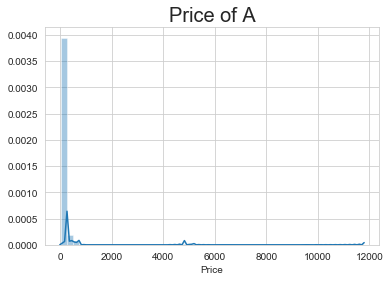

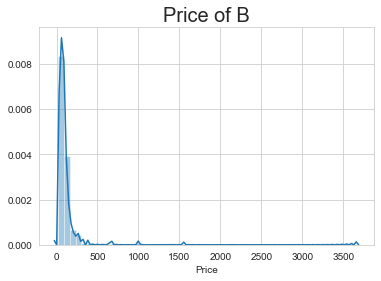

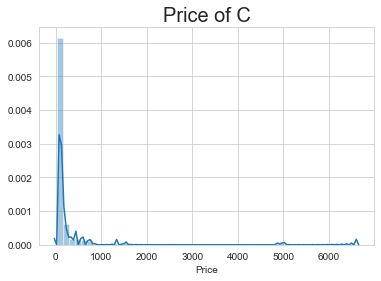

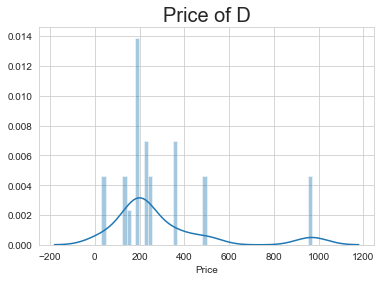

In [51]:
ax = sns.distplot(month_merge[month_merge.Classification == 'A+']['Price'], bins = 50)
ax.set_title("Price of A+", fontsize=20)
plt.show()

ax = sns.distplot(month_merge[month_merge.Classification == 'A']['Price'], bins = 50)
ax.set_title("Price of A", fontsize=20)
plt.show()

ax = sns.distplot(month_merge[month_merge.Classification == 'B']['Price'], bins = 50)
ax.set_title("Price of B", fontsize=20)
plt.show()

ax = sns.distplot(month_merge[month_merge.Classification == 'C']['Price'], bins = 50)
ax.set_title("Price of C", fontsize=20)
plt.show()

ax = sns.distplot(month_merge[month_merge.Classification == 'D']['Price'], bins = 50)
ax.set_title("Price of D", fontsize=20)
plt.show()

In [52]:
month_merge.groupby(["Classification"])['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Classification,,,,,,,,
A,351.0,171.839875,770.557129,28.0,48.000000,70.0,99.0,11758.0
A+,24.0,159.456037,167.014698,37.0,42.039340,74.0,205.0,488.0
B,564.0,107.599171,199.345460,14.0,46.768097,77.0,109.0,3646.0
C,510.0,215.850803,653.829166,29.0,53.000000,80.0,135.0,6600.0
D,23.0,296.235279,243.100099,30.0,192.000000,218.0,359.0,969.0


From three plots and table above, we can see that:
3. Luxury items maiunly in `C` and `B` class
4. Cheap item generally in `A` and `A+`

### Capacity is decided by Sale Quantity, rather than sale amount, or sell margin

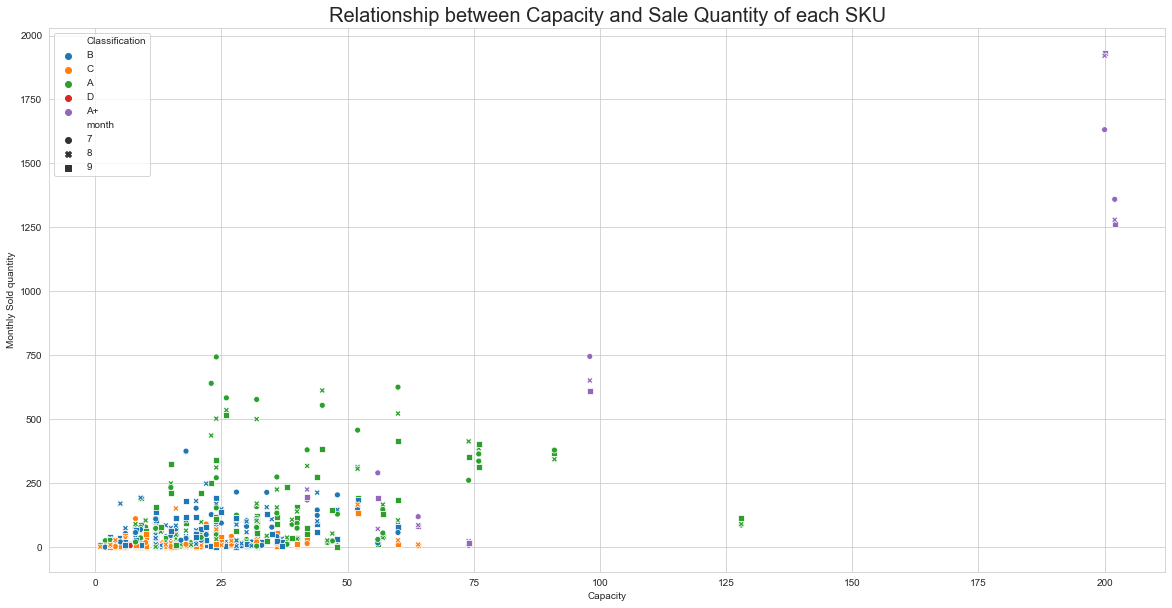

In [53]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Capacity", y="totalMonthlyQtySold", style="month", hue="Classification", data=month_merge)
ax.set_title("Relationship between Capacity and Sale Quantity of each SKU", fontsize=20)
ax.set_ylabel("Monthly Sold quantity")
plt.show()

From plot above, we can see that:

The calssification has strong relationship with the quantity sold: **the more sold Qty on average, the higher class** 

### Sell Margin of each classification

In [54]:
month_merge.groupby(["Classification"])['SellMargin'].describe()

,count,mean,std,min,25%,50%,75%,max
Classification,,,,,,,,
A,351.0,2630.074864,2831.162283,43.020000,607.065002,1630.600098,3399.004883,15873.419922
A+,24.0,16738.790469,16055.609330,312.359985,4069.699890,11076.845215,24351.012207,53821.046875
B,564.0,1105.833158,1209.285234,-9.700012,387.515015,785.620026,1383.720001,10501.769531
C,510.0,792.593823,808.385438,-269.640015,279.550018,573.735016,1004.305054,7364.229980
D,23.0,799.675240,605.445916,25.160000,264.320007,753.630005,1108.035034,2188.380127


  Classification  totalMonthlyNetSale
0              A         1.590595e+06
1             A+         7.003028e+05
2              B         1.016511e+06
3              C         6.683994e+05
4              D         2.687511e+04

Sell Margin % means: TotalSellMargin / totalMonthlyNetSale within classifiction 


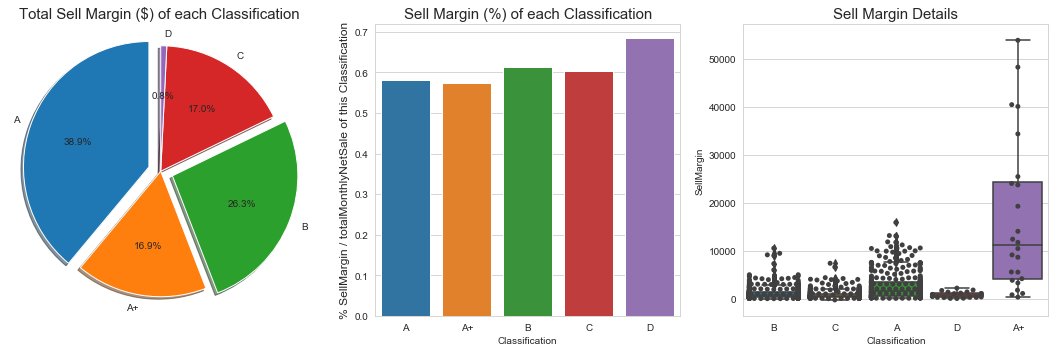

In [55]:
pie_chart_margin("SellMargin", month_merge, 'Total Sell Margin ($) of each Classification', 
                         'Sell Margin (%) of each Classification', 
                         explode = (0.1, 0, 0.1, 0, 0))

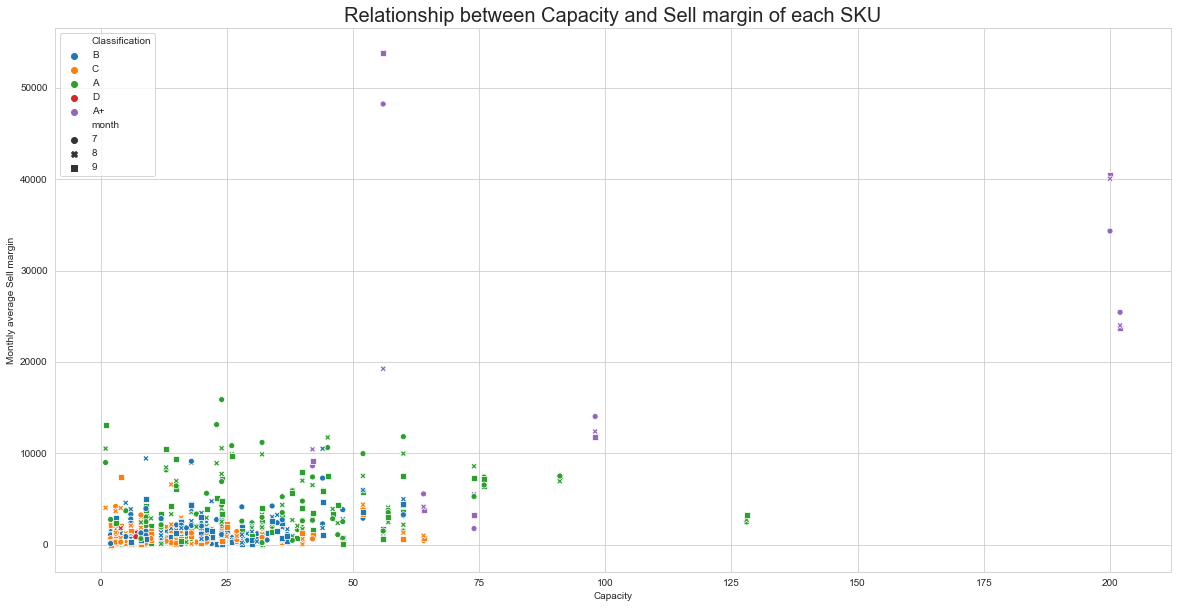

In [56]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Capacity", y="SellMargin", style="month", hue="Classification", data=month_merge)
ax.set_title("Relationship between Capacity and Sell margin of each SKU", fontsize=20)
ax.set_ylabel("Monthly average Sell margin")
plt.show()

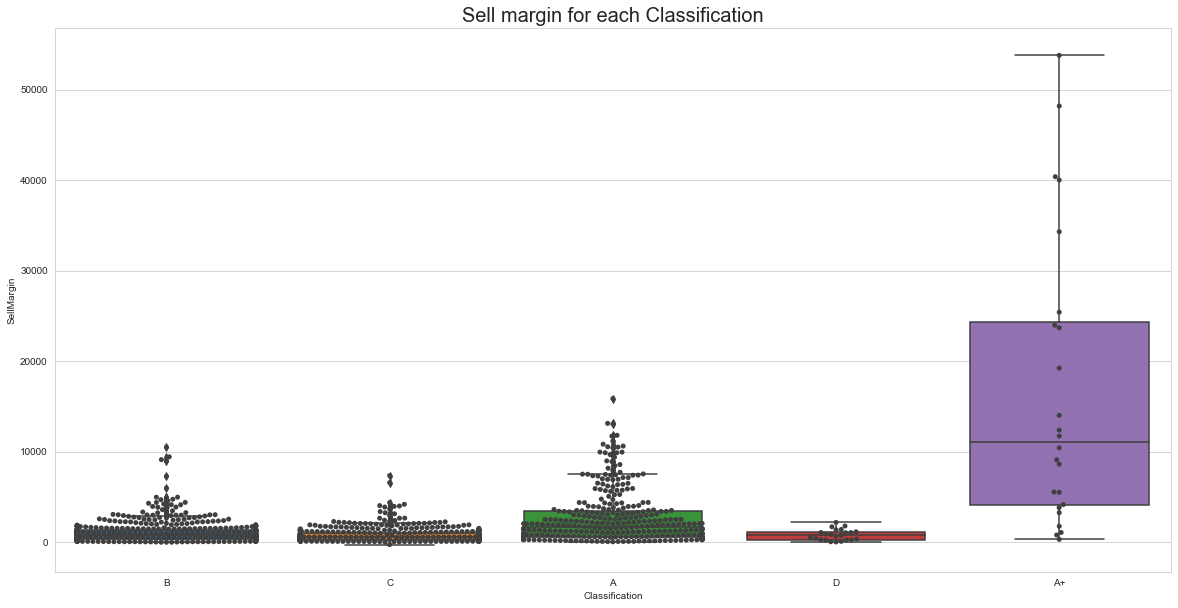

In [57]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="Classification", y="SellMargin", data=month_merge)
ax = sns.swarmplot(x="Classification", y="SellMargin", data=month_merge, color=".25")
ax.set_title("Sell margin for each Classification", fontsize=20)
plt.show()

From three plots above, we can see that:
- there is no clear relationship between capacity and sell margin
- `A+` items, which have most capacity/sold quantity doesnot have significant high sell margins, which make sense since this group items are generally cheap.
- Some items in `B` or `A` class has relatively low sell margins.
- The D classes overall has highest sell margins

#### Super high sell margin % (>0.8)
from barplot and table below we can see that:
- few high margin items are in `D`, `B` classes
- They are all below the mean of price ($70)
- `JAGERMEISTER 20 CL` is very popular (around 50-60 sell qty each month). Others are not popular.

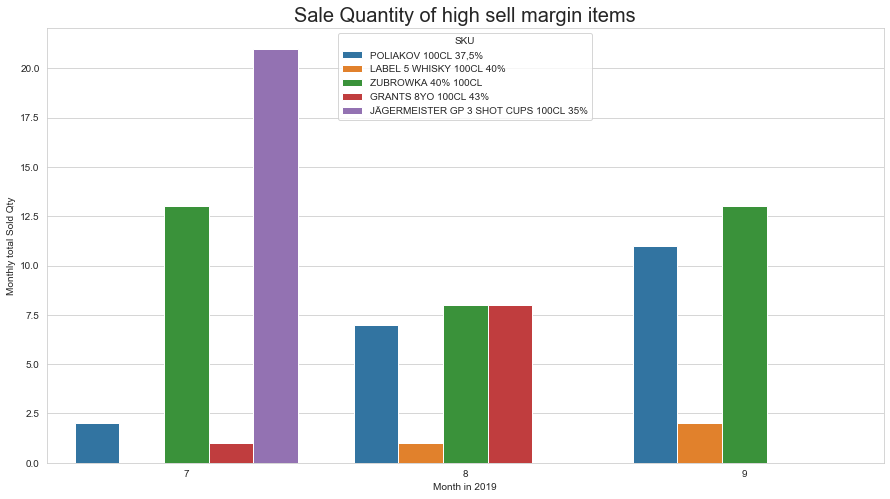

In [58]:
#### Super high sell margin
highsellmargin_item = month_merge[month_merge.SellMargin/month_merge.totalMonthlyNetSale >=0.8]

plt.figure(figsize=(15,8))
ax = sns.barplot(x="month", y="totalMonthlyQtySold", hue="SKU", data=highsellmargin_item)
ax.set_title("Sale Quantity of high sell margin items", fontsize=20)
ax.set_xlabel("Month in 2019")
ax.set_ylabel("Monthly total Sold Qty")
plt.show()

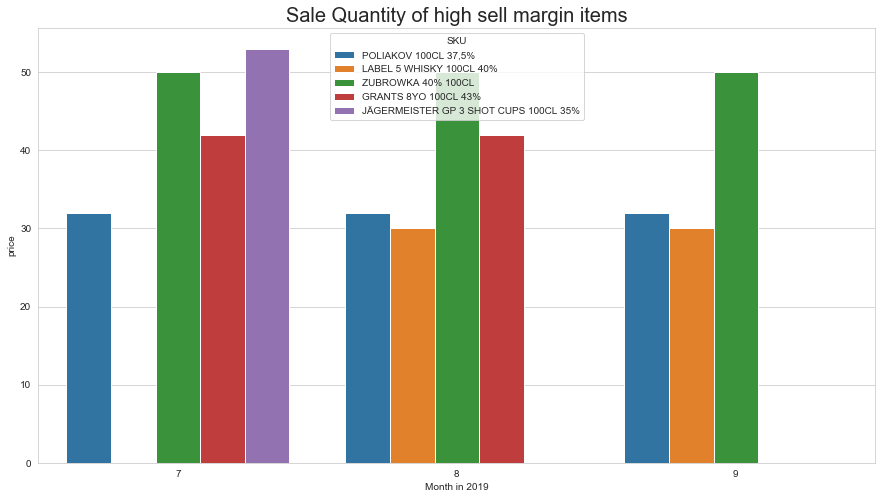

In [59]:
#### Super high sell margin
highsellmargin_item = month_merge[month_merge.SellMargin/month_merge.totalMonthlyNetSale >=0.8]

plt.figure(figsize=(15,8))
ax = sns.barplot(x="month", y="Price", hue="SKU", data=highsellmargin_item)
ax.set_title("Sale Quantity of high sell margin items", fontsize=20)
ax.set_xlabel("Month in 2019")
ax.set_ylabel("price")
plt.show()

In [60]:
highsellmargin_item

,MatID,SKU,Facings,Capacity,DaysSupply,Classification,month,SubCategory,Vendor,totalMonthlyNetSale,totalMonthlyGrossSale,avgCOGS,totalMonthlyQtySold,Price,SellMargin,avgFrontMargin
75,100593823,"POLIAKOV 100CL 37,5%",4.0,16.0,86.199997,B,8,AL ALCOOLS BLANCS,Default Vendor for Blank VendorNo,220.800003,224.0,-25.549999,7.0,32.0,195.250000,198.449997
102,100470733,LABEL 5 WHISKY 100CL 40%,2.0,8.0,0.000000,D,9,AL WHISKIES,Asahi Beverages (NZ) Ltd,60.000000,60.0,-9.680000,2.0,30.0,50.320000,50.320000
355,28003,ZUBROWKA 40% 100CL,4.0,16.0,46.700001,B,7,AL ALCOOLS BLANCS,Default Vendor for Blank VendorNo,630.000000,650.0,-101.120003,13.0,50.0,528.880005,548.880005
536,28003,ZUBROWKA 40% 100CL,4.0,16.0,46.700001,B,9,AL ALCOOLS BLANCS,Default Vendor for Blank VendorNo,642.500000,650.0,-101.080002,13.0,50.0,541.419983,548.919983
558,100593823,"POLIAKOV 100CL 37,5%",4.0,16.0,86.199997,B,9,AL ALCOOLS BLANCS,Default Vendor for Blank VendorNo,326.399994,352.0,-40.060001,11.0,32.0,286.339996,311.940002
1153,100470733,LABEL 5 WHISKY 100CL 40%,2.0,8.0,0.000000,D,8,AL WHISKIES,Asahi Beverages (NZ) Ltd,30.000000,30.0,-4.840000,1.0,30.0,25.160000,25.160000
1198,100429698,GRANTS 8YO 100CL 43%,2.0,8.0,62.200001,B,7,AL WHISKIES,William Grant And Sons Pty,39.900002,42.0,-7.760000,1.0,42.0,32.139999,34.239998
1320,100429698,GRANTS 8YO 100CL 43%,2.0,8.0,62.200001,B,8,AL WHISKIES,William Grant And Sons Pty,323.100006,336.0,-62.130001,8.0,42.0,260.970001,273.869995
1322,28003,ZUBROWKA 40% 100CL,4.0,16.0,46.700001,B,8,AL ALCOOLS BLANCS,Default Vendor for Blank VendorNo,375.000000,400.0,-62.220001,8.0,50.0,312.779999,337.779999
1414,100751854,JÄGERMEISTER GP 3 SHOT CUPS 100CL 35%,1.0,5.0,16.700001,B,7,AL LIQUEURS,Default Vendor for Blank VendorNo,1089.150024,1113.0,-212.550003,21.0,53.0,876.600037,900.450012


#### Super Low sell margin items (<0.4)
From the plot and table above, we can see that for the items have quite low sell margin:
- High sell qty items are cheap
- Low Sell qty items are expensive. 

In [61]:
#### Super high sell margin
lowsellmargin_item = month_merge[month_merge.SellMargin <0.4]

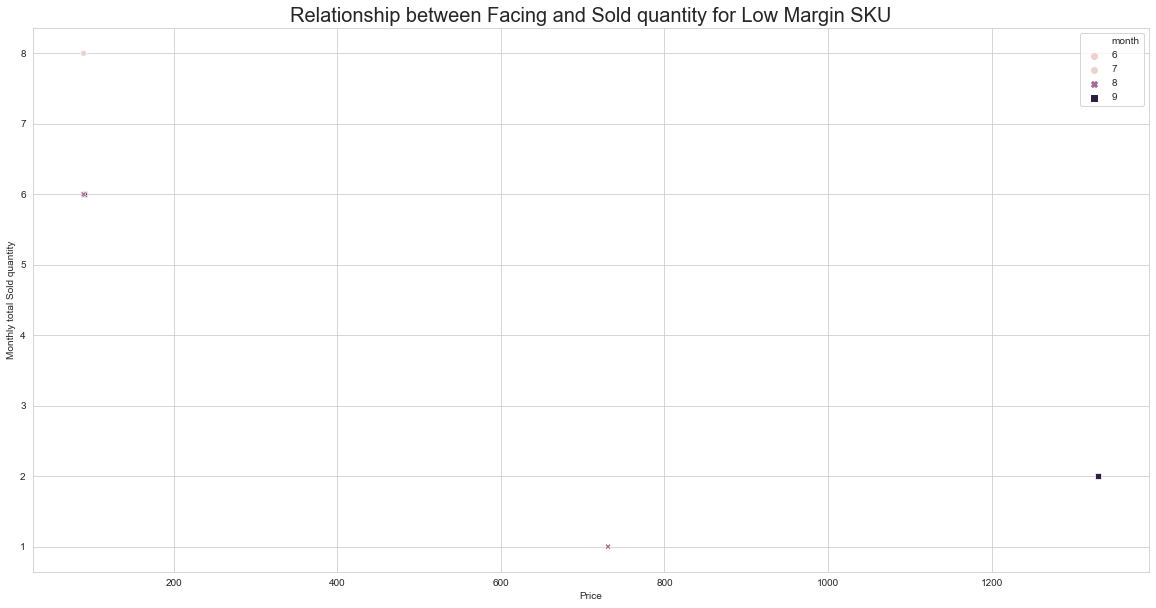

In [62]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Price", y="totalMonthlyQtySold", hue="month", style='month',data=lowsellmargin_item)
ax.set_title("Relationship between Facing and Sold quantity for Low Margin SKU", fontsize=20)
ax.set_ylabel("Monthly total Sold quantity")
plt.show()

In [63]:
"""
Details of high margin items
"""
lowsellmargin_item

,MatID,SKU,Facings,Capacity,DaysSupply,Classification,month,SubCategory,Vendor,totalMonthlyNetSale,totalMonthlyGrossSale,avgCOGS,totalMonthlyQtySold,Price,SellMargin,avgFrontMargin
52,100646986,TOBERMORY 10YO 70CL 46.3%,8.0,32.0,1120.0,B,7,AL WHISKIES,Eurovintage Ltd Ex Vintage,482.769989,720.0,-492.470001,8.0,90.0,-9.700012,227.529999
360,100646986,TOBERMORY 10YO 70CL 46.3%,8.0,32.0,1120.0,B,9,AL WHISKIES,Eurovintage Ltd Ex Vintage,363.529999,540.0,-369.350006,6.0,90.0,-5.820007,170.649994
675,100646986,TOBERMORY 10YO 70CL 46.3%,8.0,32.0,1120.0,B,8,AL WHISKIES,Eurovintage Ltd Ex Vintage,360.679993,540.0,-369.350006,6.0,90.0,-8.670013,170.649994
1048,100475664,MACALLAN RARE CASK BLACK 70CL 48%,1.0,2.0,28.0,C,8,AL WHISKIES,EDRINGTON SINGAPORE P L,0.000000,731.0,-269.640015,1.0,731.0,-269.640015,461.359985
1259,100208138,MACALLAN OSCURO 70CL 46.5%,1.0,2.0,0.0,C,9,AL WHISKIES,EDRINGTON SINGAPORE P L,1263.500000,2660.0,-1274.000000,2.0,1330.0,-10.500000,1386.000000


### facing with Price

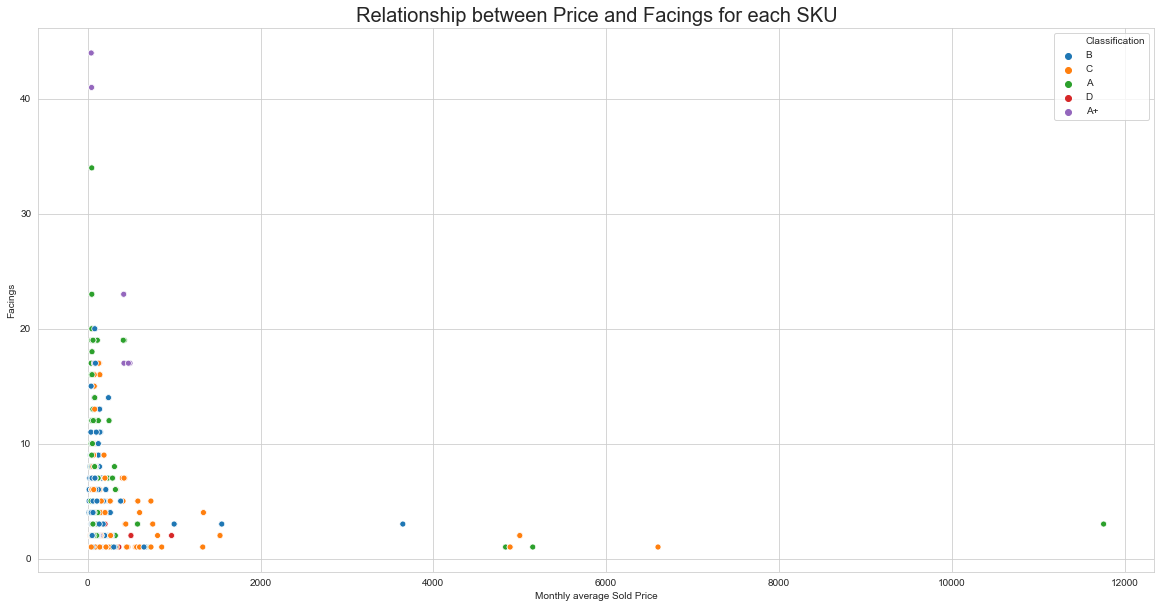

In [64]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Price", y="Facings", hue="Classification", data=month_merge)
ax.set_title("Relationship between Price and Facings for each SKU", fontsize=20)
ax.set_xlabel("Monthly average Sold Price")
plt.show()

Facing has no clear relationship with facings